# 1. Setting up the environment

In [ ]:
!pip install pillow

In [ ]:
import torch
import torchvision
import warnings

warnings.filterwarnings('ignore')

In [ ]:
print(torch.cuda.is_available())

True


# 2. Preparing the Datasets

In [ ]:
import matplotlib.pyplot as plt

from torch.utils import data 
from torchvision import datasets, transforms

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict()
args_dict = { 'image_size': 32, 
              'g_conv_dim': 32, 
              'd_conv_dim': 32,
              'init_zero_weights': False,
              'num_workers': 0,
              'n_iterations': 10000,
              'lambda_cycle': 0.1,
              'lr': 0.001,
              'beta1': 0.3,
              'beta2': 0.999,
              'batch_size_train': 64,
              'batch_size_test': 1000, 
              'test_dir': 'test_CycleGAN',
              'checkpoint_dir': 'checkpoints_CycleGAN',
              'eval_sample_dir': 'samples_CycleGAN',
              'load': None,
              'log_step': 200,
              'evaluation_time': 200,
              'checkpoint_time': 1000
             }
args.update(args_dict)

In [ ]:
mnist_train = datasets.MNIST('/content/MNIST_train',
                       transform= transforms.Compose([transforms.Resize(args.image_size),
                                                      transforms.ToTensor()]),
                       train=True, 
                       download=True)
usps_train  = datasets.USPS('/content/USPS_train',
                      transform= transforms.Compose([transforms.Resize(args.image_size),
                                                     transforms.ToTensor()]),                      
                      train=True,
                      download=True)

mnist_test = datasets.MNIST('/content/MNIST_test',
                       transform= transforms.Compose([transforms.Resize(args.image_size),
                                                      transforms.ToTensor()]),
                       train=False, 
                       download=True)
usps_test  = datasets.USPS('/content/USPS_test',
                      transform= transforms.Compose([transforms.Resize(args.image_size),
                                                     transforms.ToTensor()]),                      
                      train=False,
                      download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/MNIST_train/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST_train/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/MNIST_train/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST_train/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/MNIST_train/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST_train/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/MNIST_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST_train/MNIST/raw

Processing...
Done!



Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/MNIST_test/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST_test/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/MNIST_test/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST_test/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/MNIST_test/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST_test/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/MNIST_test/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST_test/MNIST/raw

Processing...
Done!


In [ ]:
# print datasets infos
print(mnist_train)
print()
print('Pixel values range in MNIST Train:', (mnist_train.data.numpy().min(), mnist_train.data.numpy().max()))
print('='*40)
print(usps_train)
print()
print('Pixel values range in USPS Train:', (usps_train.data.min(), usps_train.data.max()))
print('='*40)
print(mnist_test)
print()
print('Pixel values range in MNIST Test:', (mnist_test.data.numpy().min(), mnist_test.data.numpy().max()))
print('='*40)
print(usps_test)
print()
print('Pixel values range in USPS Test:', (usps_test.data.min(), usps_test.data.max()))

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/MNIST_train
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear)
               ToTensor()
           )

Pixel values range in MNIST Train: (0, 255)
Dataset USPS
    Number of datapoints: 7291
    Root location: /content/USPS_train
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear)
               ToTensor()
           )

Pixel values range in USPS Train: (0, 254)
Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/MNIST_test
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear)
               ToTensor()
           )

Pixel values range in MNIST Test: (0, 255)
Dataset USPS
    Number of datapoints: 2007
    Root location: /content/USPS_test
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bil

In [ ]:
train_loader_X = data.DataLoader(mnist_train,
                                 batch_size=args.batch_size_train, 
                                 shuffle=True)

train_loader_Y = data.DataLoader(usps_train,
                                 batch_size=args.batch_size_train, 
                                 shuffle=True)

test_loader_X = data.DataLoader(mnist_test, 
                                batch_size=args.batch_size_test, 
                                shuffle=False)

test_loader_Y = data.DataLoader(usps_test, 
                                batch_size=args.batch_size_test, 
                                shuffle=False)

In [ ]:
samples_X = enumerate(train_loader_X)
samples_Y = enumerate(train_loader_Y)
_, (sample_X, _) = next(samples_X)
_, (sample_Y, _) = next(samples_Y)
# check shapes of samples from MNIST and USPS datasets
print(sample_X.shape)
print(sample_Y.shape)
# check range of pixel values 
print(sample_X.min(), sample_X.max())
print(sample_Y.min(), sample_Y.max())

torch.Size([64, 1, 32, 32])
torch.Size([64, 1, 32, 32])
tensor(0.) tensor(1.)
tensor(0.) tensor(0.9961)


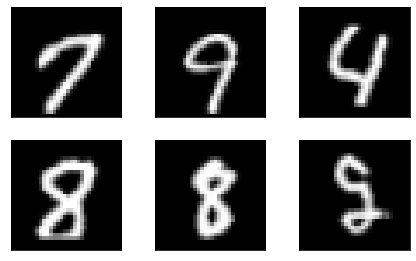

In [ ]:
fig_MNIST = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(sample_X[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
plt.show()

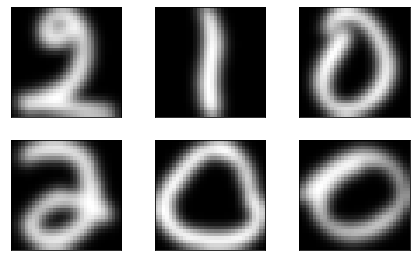

In [ ]:
fig_USPS = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(sample_Y[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
plt.show()

# 3. Cycle GAN

In [ ]:
import os
import numpy as np

import torch.nn as nn
import torch.nn.functional as Func
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import save_image

## 3.1. Helper functions

In [ ]:
def to_var(tensor):
    """
    Wraps a Tensor in a Variable, optionally placing it on the GPU.
    """
    if torch.cuda.is_available():
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)

def to_data(x):
    """
    Converts variable to numpy array.
    """
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()

In [ ]:
def cycleGAN_checkpoint(iteration, G, F, D_X, D_Y, opts):
    """
    Saves the parameters of both generators G, F and discriminators D_X, D_Y.
    iteration : int. number of iteration
    G : generator; mapping from X to Y
    F : generator; mapping from Y to X
    D_X : adversarial discriminator; encourages F to translate Y into outputs indistinguishable from domain X
    D_Y : adversarial discriminator; encourages G to translate X into outputs indistinguishable from domain Y
    opts: command-line arguments
    """
    G_path = os.path.join(opts.checkpoint_dir, 'G.pkl')
    F_path = os.path.join(opts.checkpoint_dir, 'F.pkl')
    D_X_path = os.path.join(opts.checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(opts.checkpoint_dir, 'D_Y.pkl')
    torch.save(G.state_dict(), G_path)
    torch.save(F.state_dict(), F_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def load_checkpoint(opts, train=False):
    """
    Loads the generator and discriminator models from checkpoints.
    opts : command-line arguments
    """
    G_path = os.path.join(opts.load, 'G.pkl')
    F_path = os.path.join(opts.load, 'F.pkl')
    G = CycleGenerator(conv_dim=opts.g_conv_dim, init_zero_weights=opts.init_zero_weights)
    F = CycleGenerator(conv_dim=opts.g_conv_dim, init_zero_weights=opts.init_zero_weights)
    G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
    F.load_state_dict(torch.load(F_path, map_location=lambda storage, loc: storage))

    if train:
        D_X_path = os.path.join(opts.load, 'D_X.pkl')
        D_Y_path = os.path.join(opts.load, 'D_Y.pkl')
        D_X = DCDiscriminator(conv_dim=opts.d_conv_dim)
        D_Y = DCDiscriminator(conv_dim=opts.d_conv_dim)
        D_X.load_state_dict(torch.load(D_X_path, map_location=lambda storage, loc: storage))
        D_Y.load_state_dict(torch.load(D_Y_path, map_location=lambda storage, loc: storage))

    if torch.cuda.is_available():
        print('Model moved to GPU.')
        G.cuda()
        F.cuda()
        if train:
            D_X.cuda()
            D_Y.cuda()
            return G, F, D_X, D_Y

    return G, F
       
       
def cycleGAN_save_samples(iteration, real_X, real_Y, F, G, opts):
    """
    Saves samples from both generators G:X->Y and F:Y->X.
    """
    fake_X = F(real_Y)
    fake_Y = G(real_X)
    reconstructed_X = F(fake_Y)
    reconstructed_Y = G(fake_X)

    im = torch.cat([real_X, fake_Y, reconstructed_X, real_Y, fake_X, reconstructed_Y], dim=3)
    save_image(im, args.eval_sample_dir+'/sample_{}.png'.format(iteration), nrow=3)

## 3.2. Training and Evaluation utils

In [ ]:
def print_network(G, F, D_X=None, D_Y=None):
    """
    Prints model information for generators G and F and discriminators D_X and D_Y.
    """
    print("                 G                     ")
    print("---------------------------------------")
    print(G)
    print("---------------------------------------")

    print("                 F                     ")
    print("---------------------------------------")
    print(F)
    print("---------------------------------------")
    if D_X:
        print("                 D_X                   ")
        print("---------------------------------------")
        print(D_X)
        print("---------------------------------------")
    if D_Y:
        print("                 D_Y                   ")
        print("---------------------------------------")
        print(D_Y)
        print("---------------------------------------")
      
def model(opts):
    """
    Builds generators and discriminators.
    opts: command-line arguments
    """
    G   = CycleGenerator(conv_dim=opts.g_conv_dim, init_zero_weights=opts.init_zero_weights)
    F   = CycleGenerator(conv_dim=opts.g_conv_dim, init_zero_weights=opts.init_zero_weights)
    D_X = DCDiscriminator(conv_dim=opts.d_conv_dim)
    D_Y = DCDiscriminator(conv_dim=opts.d_conv_dim)
    print_network(G, F, D_X, D_Y)

    if torch.cuda.is_available():
        G.cuda()
        F.cuda()
        D_X.cuda()
        D_Y.cuda()
        print('Models moved to GPU.')

    return G, F, D_X, D_Y

def print_arguments(opts):
    """
    Print the values of all command-line arguments.
    opts: command-line arguments
    """
    print('=' * 80)
    print('Command line arguments'.center(80))
    print('=' * 80)
    for key in opts.__dict__:
        if opts.__dict__[key]:
            print('{:>30}: {:<30}'.format(key, opts.__dict__[key]))
    print('=' * 80)

In [ ]:
def train(train_loader_X, test_loader_X, train_loader_Y, test_loader_Y, opts):
    """
    Create checkpoint and sample directories, and start training.
    """
    # Create checkpoint and sample directories
    if not os.path.exists(opts.checkpoint_dir):
        os.makedirs(opts.checkpoint_dir)
    if not os.path.exists(opts.eval_sample_dir):
        os.makedirs(opts.eval_sample_dir)
        
    # Start training
    G, F, D_X, D_Y = train_cycleGAN(train_loader_X, train_loader_Y, test_loader_X, test_loader_Y, opts)

    return G, F, D_X, D_Y
    
def test(test_loader_X, test_loader_Y, opts):
    """
    Load the latest checkpoint and run an evaluation on test sets.
    """
    G = CycleGenerator(conv_dim=opts.g_conv_dim, init_zero_weights=opts.init_zero_weights)
    F = CycleGenerator(conv_dim=opts.g_conv_dim, init_zero_weights=opts.init_zero_weights)
    print_network(G, F)
    try:
        G, F = load_checkpoint(opts)
    except:
        print(' [*] No checkpoint!')

    real_X = to_var(iter(test_loader_X).next()[0])
    real_Y = to_var(iter(test_loader_Y).next()[0])
            
    G.eval()
    F.eval()

    with torch.no_grad():
        fake_X = F(real_Y)
        fake_Y = G(real_X)
        reconstructed_X = F(fake_Y)
        reconstructed_Y = G(fake_X)

    im = torch.cat([real_X, fake_Y, reconstructed_X, real_Y, fake_X, reconstructed_Y], dim=3)

    if not os.path.isdir(args.test_dir):
        os.makedirs(args.test_dir)

    save_image(im, args.test_dir+'/test.png', nrow=3)

## 3.3. Cycle-consistent GANs

### 3.3.1. Architecture

In [ ]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=2, batch_norm=True, init_zero_weights=False):
    """
    Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    if init_zero_weights:
        conv_layer.weight.data = torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.001
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)
    

def upconv(in_channels, out_channels, kernel_size, stride=2, padding=2, batch_norm=True):
    """
    Creates a upsample-and-convolution layer, with optional batch normalization.
    """
    layers = []
    if stride > 1:
      layers.append(nn.Upsample(scale_factor=stride))
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)
  

class ResnetBlock(nn.Module):
    def __init__(self, conv_dim):
        super(ResnetBlock, self).__init__()
        self.conv_layer = conv(in_channels=conv_dim, out_channels=conv_dim, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = x + self.conv_layer(x)
        return out

In [ ]:
class CycleGenerator(nn.Module):
    """
    Defines the architecture of the generator network.
    Note: Both generators G and F have the same architecture.
    """
    def __init__(self, conv_dim=64, init_zero_weights=False):
        super(CycleGenerator, self).__init__()

        self.conv1 = conv(1, conv_dim, 5, init_zero_weights=init_zero_weights)
        self.conv2 = conv(conv_dim, conv_dim*2, 5, init_zero_weights=init_zero_weights)
        
        self.resnet_block = ResnetBlock(conv_dim * 2)

        self.upconv1 = upconv(conv_dim*2, conv_dim, 5)
        self.upconv2 = upconv(conv_dim, 1, 5, batch_norm=False)


    def forward(self, x):
        """
        Generates an image conditioned on an input image.
            Input
            -----
                x: batch_size x 1 x 32 x 32
            Output
            ------
                out: batch_size x 1 x 32 x 32
        """
        batch_size = x.size(0)

        out = Func.relu(self.conv1(x))            # batch_size x 32 x 16 x 16
        out = Func.relu(self.conv2(out))          # batch_size x 64 x 8 x 8
        out = Func.relu(self.resnet_block(out))   # batch_size x 64 x 8 x 8
        out = Func.relu(self.upconv1(out))        # batch_size x 32 x 16 x 16
        out = torch.tanh(self.upconv2(out))       # batch_size x 1 x 32 x 32

        out_size = out.size()
        if out_size != torch.Size([batch_size, 1, 32, 32]):
          raise ValueError("expect {} x 1 x 32 x 32, but get {}".format(batch_size, out_size))

        return out
        
class DCDiscriminator(nn.Module):
    """
    Defines the architecture of the discriminator network.
    Note: Both discriminators D_X and D_Y have the same architecture.
    """
    def __init__(self, conv_dim=64):
        super(DCDiscriminator, self).__init__()

        self.conv1 = conv(1, int(conv_dim/2), 5)
        self.conv2 = conv(int(conv_dim/2), conv_dim, 5)
        self.conv3 = conv(conv_dim, conv_dim * 2, 5)
        self.conv4 = conv(conv_dim * 2, 1, 5, batch_norm=False, padding=1)


    def forward(self, x):
        batch_size = x.size(0)

        out = Func.relu(self.conv1(x))      # batch_size x 16 x 16
        out = Func.relu(self.conv2(out))    # batch_size x 8 x 8
        out = Func.relu(self.conv3(out))    # batch_size x 64 x 4 x 4
        out = self.conv4(out).squeeze()

        out_size = out.size()
        if out_size != torch.Size([batch_size,]):
          raise ValueError("expect {} x 1, but get {}".format(batch_size, out_size))

        return out

### 3.3.2. Building CycleGAN

In [ ]:
def train_cycleGAN(train_dataloader_X, train_dataloader_Y, test_dataloader_X, test_dataloader_Y, opts):
    """
    Runs training of CycleGAN
        * Saves checkpoint every opts.checkpoint_every iterations
        * Saves generated samples every opts.sample_every iterations
    """

    # Create generators and discriminators
    G, F, D_X, D_Y = model(opts)

    g_params = list(G.parameters()) + list(F.parameters())          # Get generator parameters
    d_params = list(D_X.parameters()) + list(D_Y.parameters())      # Get discriminator parameters

    # Create optimizers for the generators and discriminators
    g_optimizer = optim.Adam(g_params, opts.lr, [opts.beta1, opts.beta2])
    d_optimizer = optim.Adam(d_params, opts.lr, [opts.beta1, opts.beta2])

    # Set a first batch of data for first epoch
    batch_X = iter(train_dataloader_X)
    batch_Y = iter(train_dataloader_Y)

    test_batch_X = iter(test_dataloader_X)
    test_batch_Y = iter(test_dataloader_Y)

    # Samples from test sets used to inspect model's performance evolution during the training
    eval_X = to_var(test_batch_X.next()[0])
    eval_Y = to_var(test_batch_Y.next()[0])

    n_iteration_per_epoch = min(len(batch_X), len(batch_Y))

    try:
      for iteration in range(1, opts.n_iterations + 1):
          # set a new batch of data for each epoch
          if iteration % n_iteration_per_epoch == 0:
              batch_X = iter(train_dataloader_X)
              batch_Y = iter(train_dataloader_Y)

          images_X, labels_X = batch_X.next()
          images_X, labels_X = to_var(images_X), to_var(labels_X).long().squeeze()

          images_Y, labels_Y = batch_Y.next()
          images_Y, labels_Y = to_var(images_Y), to_var(labels_Y).long().squeeze()

          # TRAIN DISCRIMINATORS D_X and D_Y
          
          d_optimizer.zero_grad()
          # Compute discriminator losses on real images
          D_X_loss = torch.mean((D_X(images_X) - 1)**2)
          D_Y_loss = torch.mean((D_Y(images_Y) - 1)**2)
          
          d_real_loss = D_X_loss + D_Y_loss
          d_real_loss.backward()
          d_optimizer.step()

          d_optimizer.zero_grad()
          # Generate fake images from domain X based on real images in domain Y
          fake_X = F(images_Y)
          # Generate fake images from domain Y based on real images in domain X
          fake_Y = G(images_X)
          # Compute discriminator losses on fake images
          D_X_loss = torch.mean(D_X(fake_X)**2)
          D_Y_loss = torch.mean(D_Y(fake_Y)**2)

          d_fake_loss = D_X_loss + D_Y_loss
          d_fake_loss.backward()
          d_optimizer.step()

          # TRAIN GENERATORS F and G
  
          ### Generator F : Y → X  
          g_optimizer.zero_grad()
          # Generate fake images from domain X based on real images in domain Y
          fake_X = F(images_Y)
          # Compute the loss of generator F based on domain X
          g_loss = torch.mean((D_X(fake_X) - 1)**2)
          # Compute cycle consistency loss Y → X → Y
          reconstructed_Y = G(fake_X)
          cycle_consistency_loss = torch.mean(torch.sum(torch.abs(images_Y - reconstructed_Y), (1,2,3)))
          
          g_loss += opts.lambda_cycle * cycle_consistency_loss
          g_loss.backward()
          g_optimizer.step()

          ### Generator G : X → Y 
          g_optimizer.zero_grad()
          # Generate fake images from domain Y based on real images in domain X
          fake_Y = G(images_X)
          # Compute loss of generator G based on domain Y
          g_loss = torch.mean((D_Y(fake_Y) - 1)**2)
          # Compute cycle consistency loss X → Y → X
          reconstructed_X = F(fake_Y)
          cycle_consistency_loss = torch.mean(torch.sum(torch.abs(images_X - reconstructed_X), (1,2,3)))
        
          g_loss += opts.lambda_cycle * cycle_consistency_loss
          g_loss.backward()
          g_optimizer.step()

          # Print the log info
          if iteration % opts.log_step == 0:
              print('Iteration [{:5d}/{:5d}] | d_real_loss: {:6.4f} | d_Y_loss: {:6.4f} | d_X_loss: {:6.4f} | '
                    'd_fake_loss: {:6.4f} | g_loss: {:6.4f}'.format(iteration, 
                                                                    opts.n_iterations, 
                                                                    d_real_loss.item(), 
                                                                    D_Y_loss.item(),
                                                                    D_X_loss.item(), 
                                                                    d_fake_loss.item(), 
                                                                    g_loss.item()))

          # Save the generated and reconstructed samples from test sets domains
          if iteration % opts.evaluation_time == 0:
              cycleGAN_save_samples(iteration, eval_X, eval_Y, F, G, opts)

          # Save the model parameters
          if iteration % opts.checkpoint_time == 0:
              cycleGAN_checkpoint(iteration, G, F, D_X, D_Y, opts)

    except KeyboardInterrupt:
        print('Exiting early from training.')
        return G, F, D_X, D_Y
      
    return G, F, D_X, D_Y

### 3.3.3. Run CycleGAN

In [ ]:
seed = 11
# Set random seed manually for reproducibility
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
# Set and print command line arguments
args.update(args_dict)
print_arguments(args)
# Train CycleGan 
G, F, D_X, D_Y = train(train_loader_X, test_loader_X, train_loader_Y, test_loader_Y, args)

                             Command line arguments                             
                    image_size: 32                            
                    g_conv_dim: 32                            
                    d_conv_dim: 32                            
                  n_iterations: 10000                         
                  lambda_cycle: 0.1                           
                            lr: 0.001                         
                         beta1: 0.3                           
                         beta2: 0.999                         
              batch_size_train: 64                            
               batch_size_test: 1000                          
                      test_dir: test_CycleGAN                 
                checkpoint_dir: checkpoints_CycleGAN          
               eval_sample_dir: samples_CycleGAN              
                      log_step: 200                           
               evaluation_time: 200  

In [ ]:
# Test CycleGAN
args['load'] = 'checkpoints_CycleGAN'
args.update()
test(test_loader_X, test_loader_Y, args)

                 G                     
---------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resnet_block): ResnetBlock(
    (conv_layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (upconv1): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

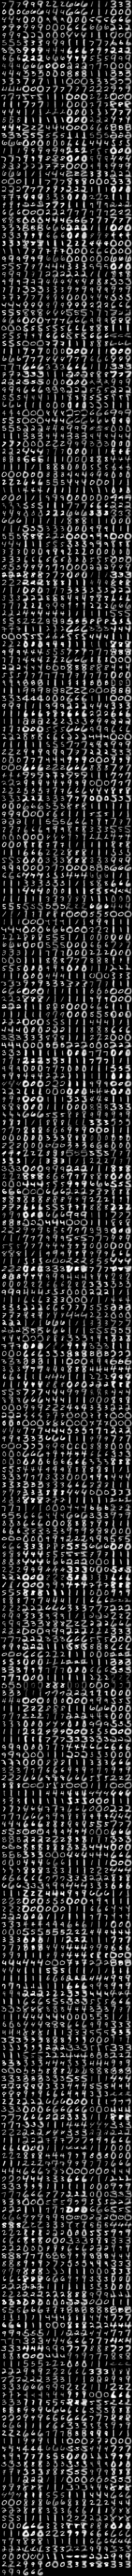

In [ ]:
from IPython.display import Image

Image("/content/test_CycleGAN/test.png")
